In [1]:
from __future__ import absolute_import, division, print_function
import pathlib
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
dataset_path = keras.utils.get_file("auto-mpg.data", "https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

32768/30286 [================================] - 0s 14us/step


'C:\\Users\\dst.FT\\.keras\\datasets\\auto-mpg.data'

In [21]:
column_names =  ['MPG', 'Cylinders', 'Displacement','Horsepower','Weight', 'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names, na_values='?', comment='\t', sep=' ', skipinitialspace=True)
dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [22]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

### I don't want to drop the rows with missing values, so I'll fill them with the average

In [23]:
dataset = dataset.fillna(dataset['Horsepower'].mean())

In [24]:
dataset.mean()

MPG               23.514573
Cylinders          5.454774
Displacement     193.425879
Horsepower       104.469388
Weight          2970.424623
Acceleration      15.568090
Model Year        76.010050
Origin             1.572864
dtype: float64

In [25]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      0
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [26]:
origin = dataset.pop('Origin')

In [27]:
dataset['USA'] = (origin == 1)*1.0
dataset['Europe'] = (origin == 1)*1.0
dataset['Japan'] = (origin == 1)*1.0
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,1.0,1.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,0.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,1.0,1.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,1.0,1.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,1.0,1.0


In [28]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

### Visualize the data

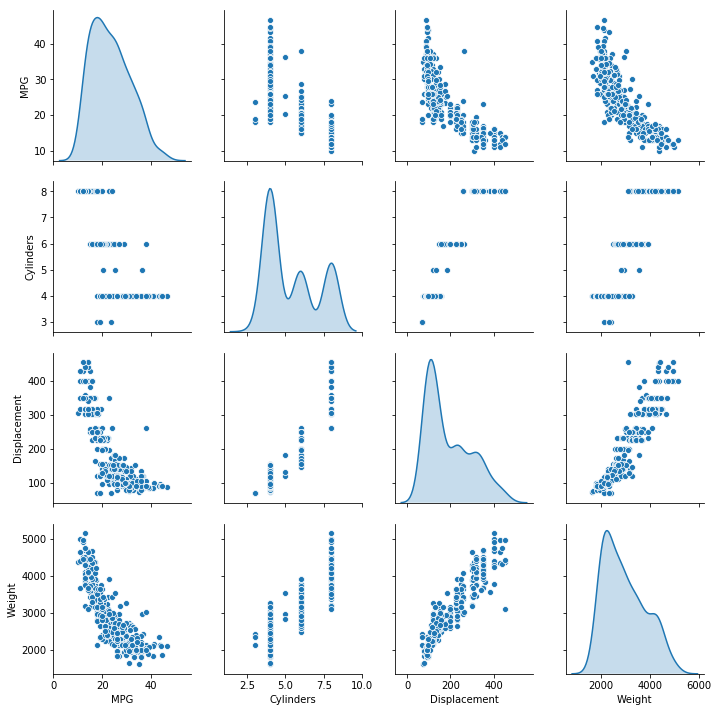

In [29]:
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

### Get some stats

In [30]:
train_stats = train_dataset.describe()
train_stats.pop('MPG')
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,318.0,5.427673,1.682941,3.0,4.00,4.0,6.00,8.0
Displacement,318.0,193.061321,103.812742,70.0,100.25,151.0,259.50,455.0
Horsepower,318.0,104.073418,38.368477,46.0,75.25,92.0,120.00,230.0
Weight,318.0,2963.823899,844.749805,1613.0,2219.25,2792.5,3571.25,5140.0
Acceleration,318.0,15.595912,2.796282,8.0,13.90,15.5,17.30,24.8
Model Year,318.0,75.946541,3.705266,70.0,73.00,76.0,79.00,82.0
USA,318.0,0.641509,0.480313,0.0,0.00,1.0,1.00,1.0
Europe,318.0,0.641509,0.480313,0.0,0.00,1.0,1.00,1.0
Japan,318.0,0.641509,0.480313,0.0,0.00,1.0,1.00,1.0


### Split data and labels

In [31]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

### Normalize the data

In [32]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)


### Build the model

In [33]:
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]),
        layers.Dense(64, activation=tf.nn.relu),
        layers.Dense(1)
    ])
    optimizer = tf.train.RMSPropOptimizer(0.001)
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae', 'mse'])
    return model

In [34]:
model = build_model()

In [35]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [36]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[ 0.6024917 ],
       [ 0.14158523],
       [ 0.41328728],
       [ 0.06577039],
       [ 0.34749702],
       [-0.05123745],
       [-0.17710213],
       [ 0.40804964],
       [ 0.6970116 ],
       [ 0.15534869]], dtype=float32)

In [37]:
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])



....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [38]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()


,val_loss,val_mean_absolute_error,val_mean_squared_error,loss,mean_absolute_error,mean_squared_error,epoch
995,7.144543,1.919796,7.144543,2.084296,0.963107,2.084296,995
996,7.167058,1.909639,7.167058,1.793939,0.848143,1.793939,996
997,7.375034,1.899507,7.375034,1.916534,0.908793,1.916534,997
998,7.206682,1.883632,7.206682,2.059141,0.956781,2.059141,998
999,8.300924,2.102556,8.300924,1.927383,0.901908,1.927383,999


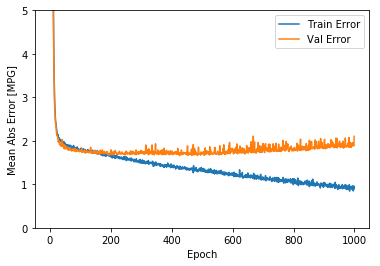

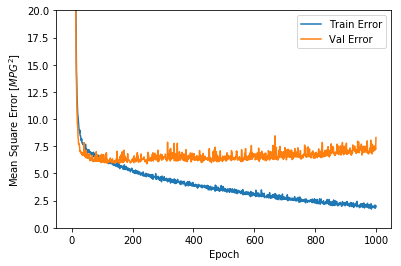

In [39]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_history(history):
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.legend()
  plt.ylim([0,5])
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  plt.legend()
  plt.ylim([0,20])

plot_history(history)



....................................................................................................
....................................................................................................
......

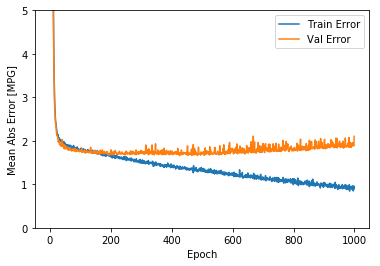

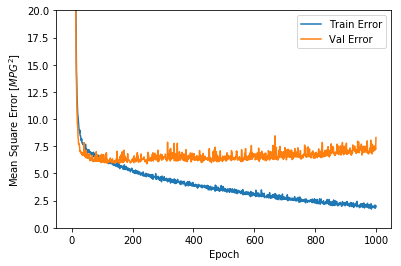

In [40]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)


In [41]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))


Testing set Mean Abs Error:  2.15 MPG


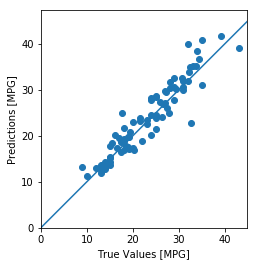

In [42]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])


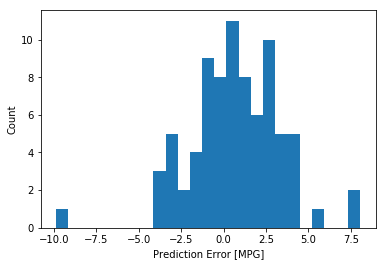

In [43]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")
